# In this sheet I will write a new file for yearly temp anomalies from 1958-2014 covering the entire Pacific Ocean

In [ ]:
import xarray as xr
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import cartopy.crs as ccrs
import numpy as np
import xesmf as xe
from   scipy.interpolate import griddata
import dask as dsk

import hvplot.xarray
import hvplot.pandas

from   cartopy import config
import cartopy.crs as ccrs
proj = ccrs.PlateCarree()

In [3]:
temp = xr.open_mfdataset("/nobackup/users/ommeren/votemper_control_monthly_highres_3D_*_CONS_v0.1.nc")
temp

<xarray.Dataset>
Dimensions:       (deptht: 75, time_counter: 684, y: 1021, x: 1442)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    nav_lat       (time_counter, y, x) float32 dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
    nav_lon       (time_counter, y, x) float32 dask.array<chunksize=(1, 1021, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 1958-01-16 ... 2014-12-16
Dimensions without coordinates: y, x
Data variables:
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 75, 1021, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    title:        Monthly mean temperature
    source:       ORAS5 - backward extension (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...

In [4]:
temp_c = temp.rename({"nav_lon":"lon","nav_lat":"lat"}).isel(y=slice(0,800))
temp_c

<xarray.Dataset>
Dimensions:       (deptht: 75, time_counter: 684, y: 800, x: 1442)
Coordinates:
  * deptht        (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
    lat           (time_counter, y, x) float32 dask.array<chunksize=(1, 800, 1442), meta=np.ndarray>
    lon           (time_counter, y, x) float32 dask.array<chunksize=(1, 800, 1442), meta=np.ndarray>
  * time_counter  (time_counter) datetime64[ns] 1958-01-16 ... 2014-12-16
Dimensions without coordinates: y, x
Data variables:
    votemper      (time_counter, deptht, y, x) float32 dask.array<chunksize=(1, 75, 800, 1442), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.4
    NCO:          netCDF Operators version 4.9.2 (Homepage = http://nco.sf.ne...
    title:        Monthly mean temperature
    source:       ORAS5 - backward extension (ECMWF)
    institution:  European Centre for Medium-Range Weather Forecasts (ECMWF) ...
    reference:    https://www.ecmwf.int/en/research/climate-reanalysis/ocean-...

In [5]:
grid_out = xe.util.grid_global(1,1)
grid_out

<xarray.Dataset>
Dimensions:  (y: 180, x: 360, y_b: 181, x_b: 361)
Coordinates:
    lon      (y, x) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
    lat      (y, x) float64 -89.5 -89.5 -89.5 -89.5 ... 89.5 89.5 89.5 89.5
    lon_b    (y_b, x_b) float64 -180.0 -179.0 -178.0 ... 178.0 179.0 180.0
    lat_b    (y_b, x_b) float64 -90.0 -90.0 -90.0 -90.0 ... 90.0 90.0 90.0 90.0
Dimensions without coordinates: y, x, y_b, x_b
Data variables:
    *empty*

In [6]:
regridder = xe.Regridder(temp_c.isel(time_counter=0).squeeze(), grid_out, "bilinear")

In [7]:
temp_out = regridder (temp_c)

temp_out = temp_out.assign_coords({'lon': temp_out.lon.isel(y=1).values, 'lat': temp_out.lat.isel(x=1).values}).rename({'x': 'lon', 'y': 'lat', 'time_counter': 'time'})#.drop_vars(['lon', 'lat'])

temp_out

<xarray.Dataset>
Dimensions:   (time: 684, deptht: 75, lat: 180, lon: 360)
Coordinates:
  * deptht    (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time      (time) datetime64[ns] 1958-01-16 1958-02-15 ... 2014-12-16
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
Data variables:
    votemper  (time, deptht, lat, lon) float32 dask.array<chunksize=(1, 75, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

### Check if the coordinates run from 180 - -180 ### 

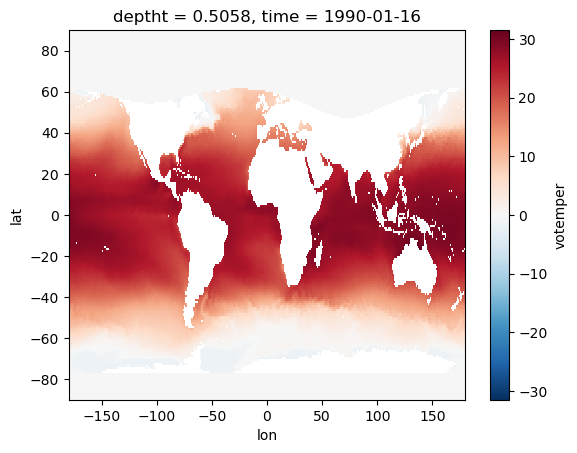

In [8]:
temp_out.votemper.sel(time='1990-01').isel(deptht=0).plot()

In [9]:
print("Original longitudes (before conversion):")
print(temp_out.lon.values)

Original longitudes (before conversion):
[-179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 -171.5 -170.5
 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5
 -159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 -139.5 -138.5 -137.5 -136.5 -135.5 -134.5 -133.5 -132.5 -131.5 -130.5
 -129.5 -128.5 -127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5
 -119.5 -118.5 -117.5 -116.5 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5
 -109.5 -108.5 -107.5 -106.5 -105.5 -104.5 -103.5 -102.5 -101.5 -100.5
  -99.5  -98.5  -97.5  -96.5  -95.5  -94.5  -93.5  -92.5  -91.5  -90.5
  -89.5  -88.5  -87.5  -86.5  -85.5  -84.5  -83.5  -82.5  -81.5  -80.5
  -79.5  -78.5  -77.5  -76.5  -75.5  -74.5  -73.5  -72.5  -71.5  -70.5
  -69.5  -68.5  -67.5  -66.5  -65.5  -64.5  -63.5  -62.5  -61.5  -60.5
  -59.5  -58.5  -57.5  -56.5  -55.5  -54.5  -53.5  -52.5  -51.5  -50.5
  -49.5  -48.5  -47.5  -46.5  -45.5 

### Change longitude from -180 to 180 to 0 to 360 ###

In [10]:
print("Original Longitudes: ", temp_out.lon.values)
#temp_out.coords['lon'] = (temp_out['lon'] + 180) % 360 
#temp_out=temp_out.sortby(temp_out.lon)
#print("Transformed Longitudes: ", temp_new.lon.values)


# Convert longitude from [-180, 180] to [0, 360]:
new_lon = np.where(temp_out.lon < 0, temp_out.lon + 360, temp_out.lon)

# Fix the case where 180 should be mapped to 360:
new_lon = np.where(new_lon == 360, 0, new_lon)

# Update the longitude in the dataset:
temp_new = temp_out.assign_coords(lon=new_lon)

# Sort the dataset by longitude:
temp_new = temp_new.sortby(temp_new.lon)

# Check the updated longitude values
print("Transformed Longitudes: ",temp_new.lon.values)

temp_new

Original Longitudes:  [-179.5 -178.5 -177.5 -176.5 -175.5 -174.5 -173.5 -172.5 -171.5 -170.5
 -169.5 -168.5 -167.5 -166.5 -165.5 -164.5 -163.5 -162.5 -161.5 -160.5
 -159.5 -158.5 -157.5 -156.5 -155.5 -154.5 -153.5 -152.5 -151.5 -150.5
 -149.5 -148.5 -147.5 -146.5 -145.5 -144.5 -143.5 -142.5 -141.5 -140.5
 -139.5 -138.5 -137.5 -136.5 -135.5 -134.5 -133.5 -132.5 -131.5 -130.5
 -129.5 -128.5 -127.5 -126.5 -125.5 -124.5 -123.5 -122.5 -121.5 -120.5
 -119.5 -118.5 -117.5 -116.5 -115.5 -114.5 -113.5 -112.5 -111.5 -110.5
 -109.5 -108.5 -107.5 -106.5 -105.5 -104.5 -103.5 -102.5 -101.5 -100.5
  -99.5  -98.5  -97.5  -96.5  -95.5  -94.5  -93.5  -92.5  -91.5  -90.5
  -89.5  -88.5  -87.5  -86.5  -85.5  -84.5  -83.5  -82.5  -81.5  -80.5
  -79.5  -78.5  -77.5  -76.5  -75.5  -74.5  -73.5  -72.5  -71.5  -70.5
  -69.5  -68.5  -67.5  -66.5  -65.5  -64.5  -63.5  -62.5  -61.5  -60.5
  -59.5  -58.5  -57.5  -56.5  -55.5  -54.5  -53.5  -52.5  -51.5  -50.5
  -49.5  -48.5  -47.5  -46.5  -45.5  -44.5  -43.5  -42.

<xarray.Dataset>
Dimensions:   (time: 684, deptht: 75, lat: 180, lon: 360)
Coordinates:
  * deptht    (deptht) float32 0.5058 1.556 2.668 ... 5.698e+03 5.902e+03
  * time      (time) datetime64[ns] 1958-01-16 1958-02-15 ... 2014-12-16
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    votemper  (time, deptht, lat, lon) float32 dask.array<chunksize=(1, 75, 180, 360), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

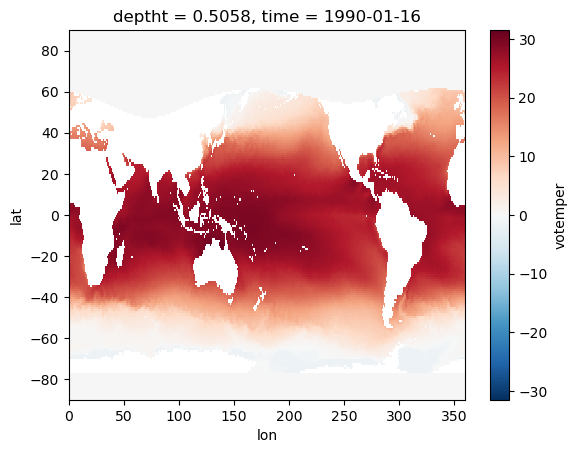

In [10]:
temp_new.votemper.sel(time='1990-01').isel(deptht=0).plot()

### Cut out Pacific ###

#### Try 1 ####

In [13]:
#setting up a mask: 
lon_min, lon_max = 120, 290

#setting the min and max depth 
deptht_min, deptht_max = 0.5058, 500

#creating a mask for the area 
mask_a = ((temp_new.lon >= lon_min) & (temp_new.lon <= lon_max))

#creating a mask for the depth 
mask_d = ((temp_new.deptht >= deptht_min) & (temp_new.deptht <= deptht_max))

#Placing the mask on the data 
temp_new_cut = temp_new.where(mask_a & mask_d, drop=True) 
temp_new_cut

<xarray.Dataset>
Dimensions:   (time: 684, deptht: 38, lat: 180, lon: 170)
Coordinates:
  * deptht    (deptht) float32 1.556 2.668 3.856 5.14 ... 370.7 411.8 457.6
  * time      (time) datetime64[ns] 1958-01-16 1958-02-15 ... 2014-12-16
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
Data variables:
    votemper  (time, deptht, lat, lon) float32 dask.array<chunksize=(1, 38, 180, 170), meta=np.ndarray>
Attributes:
    regrid_method:  bilinear

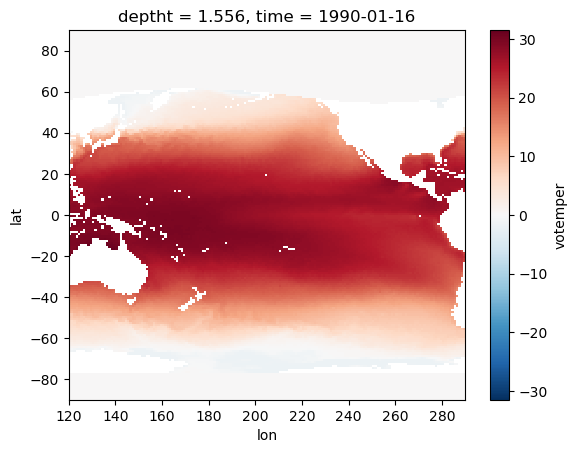

In [14]:
temp_new_cut.votemper.sel(time='1990-01').isel(deptht=0).plot()

In [15]:
# Original and transformed longitude arrays
original_lon = temp_out.lon.values
transformed_lon = temp_new_cut.lon.values

# Create a dictionary to map transformed to original longitudes
lon_mapping = dict(zip(transformed_lon, original_lon))

# Print the mapping for verification
print("Longitude Mapping (Transformed -> Original):")
for new, old in lon_mapping.items():
    print(f"{new} -> {old}")

Longitude Mapping (Transformed -> Original):
120.5 -> -179.5
121.5 -> -178.5
122.5 -> -177.5
123.5 -> -176.5
124.5 -> -175.5
125.5 -> -174.5
126.5 -> -173.5
127.5 -> -172.5
128.5 -> -171.5
129.5 -> -170.5
130.5 -> -169.5
131.5 -> -168.5
132.5 -> -167.5
133.5 -> -166.5
134.5 -> -165.5
135.5 -> -164.5
136.5 -> -163.5
137.5 -> -162.5
138.5 -> -161.5
139.5 -> -160.5
140.5 -> -159.5
141.5 -> -158.5
142.5 -> -157.5
143.5 -> -156.5
144.5 -> -155.5
145.5 -> -154.5
146.5 -> -153.5
147.5 -> -152.5
148.5 -> -151.5
149.5 -> -150.5
150.5 -> -149.5
151.5 -> -148.5
152.5 -> -147.5
153.5 -> -146.5
154.5 -> -145.5
155.5 -> -144.5
156.5 -> -143.5
157.5 -> -142.5
158.5 -> -141.5
159.5 -> -140.5
160.5 -> -139.5
161.5 -> -138.5
162.5 -> -137.5
163.5 -> -136.5
164.5 -> -135.5
165.5 -> -134.5
166.5 -> -133.5
167.5 -> -132.5
168.5 -> -131.5
169.5 -> -130.5
170.5 -> -129.5
171.5 -> -128.5
172.5 -> -127.5
173.5 -> -126.5
174.5 -> -125.5
175.5 -> -124.5
176.5 -> -123.5
177.5 -> -122.5
178.5 -> -121.5
179.5 -> -1

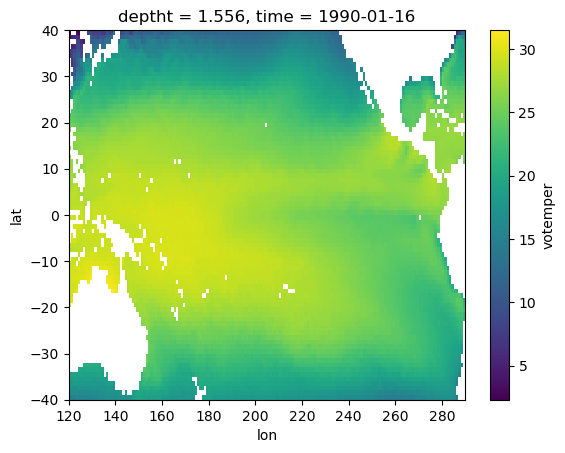

In [13]:
#plot that matches "path map"
temp_new_cut.votemper.sel(time='1990-01', lat=slice(-40, 40)).isel(deptht=0).plot()


### Calculate Anomalies ###

In [25]:
datyr = temp_new_cut.resample(time='1YE').mean('time') 
datclim = datyr.mean('time')
dat_anom = datyr-datclim 
dat_anom

<xarray.Dataset>
Dimensions:   (deptht: 38, lat: 180, lon: 170, time: 57)
Coordinates:
  * deptht    (deptht) float32 1.556 2.668 3.856 5.14 ... 370.7 411.8 457.6
  * lat       (lat) float64 -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon       (lon) float64 120.5 121.5 122.5 123.5 ... 286.5 287.5 288.5 289.5
  * time      (time) datetime64[ns] 1958-12-31 1959-12-31 ... 2014-12-31
Data variables:
    votemper  (time, deptht, lat, lon) float32 dask.array<chunksize=(1, 38, 180, 170), meta=np.ndarray>

In [26]:
dat_anom = dat_anom.compute()

### Write over to file ###

In [27]:
output_file = "full_pacific_ocean_temperature_yearly_anomalies_58-14.nc"
dat_anom.to_netcdf("/nobackup/users/ommeren/full_pacific_ocean_temperature_yearly_anomalies_58-14.nc")